In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
import calendar
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
import operator

In [2]:
df=pd.read_csv('../Data/energydata_complete.csv',index_col='date',header=0)
df['datetime'] = df.index
df['datetime'] = pd.to_datetime(df['datetime'])
df['day_of_week']=df['datetime'].dt.strftime('%w').astype('int64')
df['month']=df['datetime'].dt.strftime('%m').astype('int64')
df['hour']=df['datetime'].dt.hour
df['day_number']=df['datetime'].dt.day
df['Week_no'] = df['datetime'].dt.strftime('%W').astype('int64')
df['min'] = df['datetime'].dt.minute
df['day_of_week']=df['day_of_week'].apply(str)
df['hour']=df['hour'].apply(str)
df['min']=df['min'].apply(str)
df['period']=df[['day_of_week','hour','min']].apply(lambda x:''.join(x),axis=1)


In [3]:
phase = df.groupby(['date','month','day_of_week','hour','day_number','min','datetime','period']).mean()
phase["Total"]=phase["Appliances"] + phase["lights"]
phase = phase.reset_index()
phase.set_index('date', inplace=True)
phase['datetime'] = df.index
phase['datetime'] = pd.to_datetime(phase['datetime'])
phase['day_of_week']=phase['day_of_week'].apply(int)
phase['hour']=phase['hour'].apply(int)
phase['min']=phase['min'].apply(int)
phase['period']=phase['period'].apply(int)
phase['Press_mm_hg'] = np.log(phase['Press_mm_hg'])
phase['Visibility'] = np.log(phase['Visibility'])

In [4]:
phase1 = phase
phase1.drop(['datetime','Total','rv1','rv2'],axis=1,inplace=True)
y = phase1["Appliances"]
X=phase1.drop("Appliances",axis=1)

# 1.1 Features Selected Using EDA

## 1.1.1 RMSE,MAPE,R2,MAE calculation

In [5]:
rmse_dict = {}    
def rmse(correct,estimated):
    rmse_val = np.sqrt(mean_squared_error(correct,estimated)) 
    return rmse_val

def calc_error_metric(name,modelname, model, X_train, y_train, X_test, y_test):
    
    y_train_predicted = model.predict(X_train)
    y_test_predicted = model.predict(X_test)
        
    #MAE, RMS, MAPE, R2
    
    r2_train = r2_score(y_train, y_train_predicted)
    r2_test = r2_score(y_test, y_test_predicted)
    
    rms_train = rmse(y_train, y_train_predicted)
    rms_test = rmse(y_test, y_test_predicted)
        
    mae_train = mean_absolute_error(y_train, y_train_predicted)
    mae_test = mean_absolute_error(y_test, y_test_predicted)
        
    mape_train = np.mean(np.abs((y_train - y_train_predicted) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_test_predicted) / y_test)) * 100
    
    rmse_dict[modelname] = rms_test
        
    df_local = pd.DataFrame({'Model':[name],
                            'ModelType':[modelname],
                            'r2_train': [r2_train],
                            'r2_test': [r2_test],
                            'rms_train':[rms_train], 
                            'rms_test': [rms_test],
                            'mae_train': [mae_train],
                            'mae_test': [mae_test],
                            'mape_train':[mape_train],
                            'mape_test':[mape_test]})

    error_metric = pd.concat([df_local])
 
    return error_metric

## 1.1.2 RandomForest,LinearRegression,NeuralNetwork 

In [6]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

metric = pd.DataFrame({'Model':[],
                            'ModelType':[],
                            'r2_train': [],
                            'r2_test': [],
                            'rms_train':[], 
                            'rms_test': [],
                            'mae_train': [],
                            'mae_test': [],
                            'mape_train':[],
                            'mape_test':[]})


def models(name,X_train, y_train, X_test, y_test):
    global metric
    n = name

    # Linear Regression
    lm = linear_model.LinearRegression()
    modellinear = lm.fit(X_train,y_train)
    linear = calc_error_metric(n ,modellinear,lm, X_train, y_train, X_test, y_test)
    print("LINEAR")
    print(linear)
    
    # Random Forest
    rf = RandomForestRegressor(n_estimators =500, random_state = 1)
    modelrandomforest = rf.fit(X_train,y_train)
    randomforest = calc_error_metric(name,modelrandomforest,rf, X_train, y_train, X_test, y_test)

    # Neural Network
    nn = MLPRegressor(activation='relu',learning_rate='adaptive',alpha=0.55)
    modelneuralnetwork = nn.fit(X_train, y_train)
    neuralnetwork = calc_error_metric(name,modelneuralnetwork, nn, X_train, y_train, X_test, y_test)
    
    
    metric = pd.concat([metric,linear,randomforest,neuralnetwork])
    return metric

## 1.1.3 Training Testing split

#### 1.1.3.1  Selected Features from Exploratory Data Analysis

In [8]:
X = phase[['lights','hour','T1','RH_1','RH_5','RH_6','RH_8','T_out','Windspeed','Visibility','Tdewpoint']]
y = phase['Appliances']

In [9]:
# Test and Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [9]:
teston = models('EDA',X_train, y_train, X_test, y_test)

LINEAR
  Model                                          ModelType   mae_test  \
0   EDA  LinearRegression(copy_X=True, fit_intercept=Tr...  54.738137   

   mae_train  mape_test  mape_train   r2_test  r2_train   rms_test  rms_train  
0  54.655463  64.403084   62.843287  0.108627  0.109353  95.830482   97.16432  


In [10]:
teston

,Model,ModelType,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,EDA,"LinearRegression(copy_X=True, fit_intercept=Tr...",54.738137,54.655463,64.403084,62.843287,0.108627,0.109353,95.830482,97.164320
0,EDA,"(DecisionTreeRegressor(criterion='mse', max_de...",33.896720,12.718226,34.569303,12.628072,0.529036,0.933345,69.657464,26.580979
0,EDA,"MLPRegressor(activation='relu', alpha=0.55, ba...",52.358385,52.000473,59.838727,57.854782,0.170511,0.175338,92.444114,93.495818


#### 1.1.3.2 Selecting Features After Scaling

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
teston = models('After Scaling',X_train, y_train, X_test, y_test)

LINEAR
           Model                                          ModelType  \
0  After Scaling  LinearRegression(copy_X=True, fit_intercept=Tr...   

    mae_test  mae_train  mape_test  mape_train   r2_test  r2_train   rms_test  \
0  54.738137  54.655463  64.403084   62.843287  0.108627  0.109353  95.830482   

   rms_train  
0   97.16432  


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [12]:
teston

,Model,ModelType,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,After Scaling,"LinearRegression(copy_X=True, fit_intercept=Tr...",54.738137,54.655463,64.403084,62.843287,0.108627,0.109353,95.830482,97.164320
0,After Scaling,"(DecisionTreeRegressor(criterion='mse', max_de...",33.912640,12.717627,34.588777,12.635847,0.528682,0.933351,69.683667,26.579837
0,After Scaling,"MLPRegressor(activation='relu', alpha=0.55, ba...",51.975635,51.233277,59.803273,57.245475,0.188296,0.205471,91.447702,91.771756


## 1.1.4 Best Model

In [14]:
best_model =  min(rmse_dict.items(),key=operator.itemgetter(1))[0]
print('Best Model is ', best_model)

Best Model is  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)


# Feature Selection

# 1.2 Using Boruto Python Package

In [7]:
X_boruta = phase1
X_boruta = X_boruta.drop(['Appliances'],axis=1)
X_boruta = X_boruta.values

In [8]:
y_boruta = phase1
y_boruta = y_boruta['Appliances']
y_boruta = y.values

In [ ]:
import pandas as pd
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

# NOTE BorutaPy accepts numpy arrays only, hence the .values attribute
y_boruta = y_boruta.ravel()

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf1 = RandomForestRegressor(n_jobs=-1, max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf1, n_estimators='auto', verbose=5, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X_boruta,y_boruta)

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
#X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	10
Rejected: 	11


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	10
Rejected: 	11


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	11
Tentative: 	10
Rejected: 	11


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	11
Tentative: 	10
Rejected: 	11


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	9
Rejected: 	11


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	9
Rejected: 	11


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	9
Rejected: 	11


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	9
Rejected: 	11


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	13
Tentative: 	8
Rejected: 	11


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	13
Tentative: 	8
Rejected: 	11


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	13
Tentative: 	8
Rejected: 	11


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	13
Tentative: 	7
Rejected: 	12


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	13
Tentative: 	7
Rejected: 	12


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	13
Tentative: 	7
Rejected: 	12


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	13
Tentative: 	7
Rejected: 	12


In [ ]:
print(feat_selector.ranking_)

In [ ]:
phase.dtypes

In [ ]:
5->lights
4->T1
1->RH_2
8->RH_3
2->RH_4
5->T5
7->Press_mm_hg
3->Visibility

### 1.2.1 Feature Selected 

#### 12.1.1 Training Testing Spliting

In [ ]:
X = phase1[['lights','T1','RH_2','RH_3','RH_4','T5','Press_mm_hg','Visibility']]
y = phase1['Appliances']

In [ ]:
# Test and Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
teston = models('Boruta',X_train, y_train, X_test, y_test)

In [ ]:
teston

In [ ]:
#### After scaling boruta

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

teston = models('After Scaling_boruta',X_train, y_train, X_test, y_test)


In [ ]:
teston

## 1.3 Using featuretools
### It is a framework to perform automated feature engineering. It excels at transforming transactional and relational datasets into feature matrices for machine learning.

In [7]:
import featuretools as ft

In [8]:
phase_featuretools = df.groupby(['date','month','day_of_week','hour','day_number','min','period']).mean()
phase_featuretools = phase_featuretools.reset_index()
phase_featuretools['day_of_week']=phase_featuretools['day_of_week'].apply(int)
phase_featuretools['hour']=phase_featuretools['hour'].apply(int)
phase_featuretools['min']=phase_featuretools['min'].apply(int)
phase_featuretools['period']=phase_featuretools['period'].apply(int)
phase_featuretools['date'] = pd.to_datetime(phase_featuretools['date'])
phase_featuretools['Press_mm_hg'] = np.log(phase_featuretools['Press_mm_hg'])
phase_featuretools['Visibility'] = np.log(phase_featuretools['Visibility'])
phase_featuretools = phase_featuretools.drop(['rv1','rv2'],axis=1)

In [9]:
y_featuretools = phase_featuretools[['date','Appliances']]
X_featuretools = phase_featuretools.drop(['Appliances'],axis=1)
entities ={"appliances" :(y_featuretools,"date"),
          "rest" :(X_featuretools,"date")}
relationships = [("appliances","date","rest","date")]

In [10]:
feature_matrix_app,features_defs = ft.dfs(entities=entities,relationships=relationships,target_entity="appliances")

In [11]:
feature_matrix_app1 = feature_matrix_app

In [12]:
feature_matrix_app1.dtypes

Appliances                  int64
SUM(rest.month)             int64
SUM(rest.day_of_week)       int64
SUM(rest.hour)              int64
SUM(rest.day_number)        int64
SUM(rest.min)               int64
SUM(rest.period)            int64
SUM(rest.lights)            int64
SUM(rest.T1)              float64
SUM(rest.RH_1)            float64
SUM(rest.T2)              float64
SUM(rest.RH_2)            float64
SUM(rest.T3)              float64
SUM(rest.RH_3)            float64
SUM(rest.T4)              float64
SUM(rest.RH_4)            float64
SUM(rest.T5)              float64
SUM(rest.RH_5)            float64
SUM(rest.T6)              float64
SUM(rest.RH_6)            float64
SUM(rest.T7)              float64
SUM(rest.RH_7)            float64
SUM(rest.T8)              float64
SUM(rest.RH_8)            float64
SUM(rest.T9)              float64
SUM(rest.RH_9)            float64
SUM(rest.T_out)           float64
SUM(rest.Press_mm_hg)     float64
SUM(rest.RH_out)          float64
SUM(rest.Winds

#### 1.3.1 Test Train Split

In [13]:
y_featuretools = y_featuretools.drop('date',axis=1)
y_featuretools = y_featuretools.values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix_app1, y_featuretools, test_size=0.30, random_state=42)

In [15]:
teston = models('featuretools',X_train, y_train, X_test, y_test)

LINEAR
          Model                                          ModelType  \
0  featuretools  LinearRegression(copy_X=True, fit_intercept=Tr...   

       mae_test     mae_train     mape_test    mape_train  r2_test  r2_train  \
0  3.100581e-13  3.079378e-13  4.730477e-13  4.692747e-13      1.0       1.0   

       rms_test     rms_train  
0  4.023106e-13  3.991463e-13  


/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


KeyboardInterrupt: 

In [ ]:
teston

#### 1.3.2 After scaling featuretools

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
teston = models('After Scaling_featuretools',X_train, y_train, X_test, y_test)

In [ ]:
teston

## 1.4 Using tsfresh

In [10]:
phase_tsfresh = phase_featuretools

In [11]:
from tsfresh import extract_features

/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [12]:
X_tsfresh = phase_tsfresh.drop('Appliances',axis=1)
y_tsfresh = phase_tsfresh['Appliances']

In [13]:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute




In [14]:
p = phase_featuretools.drop('Appliances',axis=1)

In [15]:
# For Extracing Minimal Features
from tsfresh.feature_extraction import MinimalFCParameters
extracted_features = extract_features(p, column_id="date", column_sort="period",show_warnings=False, default_fc_parameters=MinimalFCParameters())

Feature Extraction: 100%|██████████| 20/20 [00:56<00:00,  2.84s/it]


In [16]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
# for extracting relevant features
impute(extracted_features)
features_filtered = select_features(extracted_features, y)

#### 1.4.1 Test and Train Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features_filtered, y, test_size=0.30, random_state=42)

In [18]:
tsfresh = models('tsfresh',X_train, y_train, X_test, y_test)

LINEAR
     Model                                          ModelType  mae_test  \
0  tsfresh  LinearRegression(copy_X=True, fit_intercept=Tr...  53.02121   

   mae_train  mape_test  mape_train   r2_test  r2_train   rms_test  rms_train  
0  52.843056  62.392016   60.635439  0.168859  0.171669  92.536131  93.703534  


In [19]:
tsfresh 

,Model,ModelType,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,tsfresh,"LinearRegression(copy_X=True, fit_intercept=Tr...",53.021210,52.843056,62.392016,60.635439,0.168859,0.171669,92.536131,93.703534
0,tsfresh,"(DecisionTreeRegressor(criterion='mse', max_de...",32.592461,12.334478,32.352695,12.024886,0.546053,0.934848,68.387492,26.279544
0,tsfresh,"MLPRegressor(activation='relu', alpha=0.55, ba...",48.811336,48.148924,51.915857,49.460150,0.181200,0.193453,91.846514,92.463200


#### 1.4.2 After scaling tsfresh

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
teston = models('After Scaling_tsfresh',X_train, y_train, X_test, y_test)

LINEAR
                   Model                                          ModelType  \
0  After Scaling_tsfresh  LinearRegression(copy_X=True, fit_intercept=Tr...   

    mae_test  mae_train  mape_test  mape_train   r2_test  r2_train   rms_test  \
0  52.968279  52.847314  62.388528   60.725148  0.169117  0.171448  92.521727   

   rms_train  
0  93.716054  


In [22]:
teston

,Model,ModelType,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,tsfresh,"LinearRegression(copy_X=True, fit_intercept=Tr...",53.021210,52.843056,62.392016,60.635439,0.168859,0.171669,92.536131,93.703534
0,tsfresh,"(DecisionTreeRegressor(criterion='mse', max_de...",32.592461,12.334478,32.352695,12.024886,0.546053,0.934848,68.387492,26.279544
0,tsfresh,"MLPRegressor(activation='relu', alpha=0.55, ba...",48.811336,48.148924,51.915857,49.460150,0.181200,0.193453,91.846514,92.463200
0,After Scaling_tsfresh,"LinearRegression(copy_X=True, fit_intercept=Tr...",52.968279,52.847314,62.388528,60.725148,0.169117,0.171448,92.521727,93.716054
0,After Scaling_tsfresh,"(DecisionTreeRegressor(criterion='mse', max_de...",32.630809,12.328393,32.378313,12.030228,0.545768,0.934940,68.408937,26.261072
0,After Scaling_tsfresh,"MLPRegressor(activation='relu', alpha=0.55, ba...",48.645106,47.000525,55.551459,52.965478,0.301070,0.361856,84.857588,82.245725


## 1.5 tpot 

### 1.5.1 training testing spliting

In [8]:
X_tpot = phase.drop(['Appliances'],axis=1)
y_tpot = phase['Appliances']

In [9]:
# Test and Train Split
X_train, X_test, y_train, y_test = train_test_split(X_tpot, y_tpot, test_size=0.3, random_state=42)

### 1.5.2 pipeline

In [10]:
from tpot import TPOTRegressor
pipeline_optimizer = TPOTRegressor()

/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)
/Users/rishabhjain/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
pipeline_optimizer = TPOTRegressor(generations=10, population_size=20, cv = 3,
                                    random_state=42, verbosity=2)

In [13]:
pipeline_optimizer.fit(X_train,y_train)

Optimization Progress:  18%|█▊        | 40/220 [04:58<15:25,  5.14s/pipeline] 

Generation 1 - Current best internal CV score: -5462.105355916628


Optimization Progress:  27%|██▋       | 60/220 [16:49<31:25, 11.78s/pipeline]  

Generation 2 - Current best internal CV score: -5462.105355916628


Optimization Progress:  38%|███▊      | 84/220 [40:09<47:38, 21.02s/pipeline]   

Generation 3 - Current best internal CV score: -5462.105355916628


Optimization Progress:  47%|████▋     | 104/220 [44:18<24:14, 12.54s/pipeline] 

Generation 4 - Current best internal CV score: -5462.105355916628


Optimization Progress:  56%|█████▋    | 124/220 [49:54<33:31, 20.95s/pipeline]

Generation 5 - Current best internal CV score: -5462.105355916628


Optimization Progress:  65%|██████▌   | 144/220 [56:14<27:25, 21.65s/pipeline]  

Generation 6 - Current best internal CV score: -5447.387656797821


Optimization Progress:  75%|███████▍  | 164/220 [1:02:53<18:57, 20.31s/pipeline]

Generation 7 - Current best internal CV score: -5447.313903685393


Optimization Progress:  84%|████████▎ | 184/220 [1:08:37<12:10, 20.30s/pipeline]

Generation 8 - Current best internal CV score: -5447.313903685393


Optimization Progress:  93%|█████████▎| 205/220 [1:19:28<19:18, 77.26s/pipeline] 

Generation 9 - Current best internal CV score: -5330.967706336275


Generation 10 - Current best internal CV score: -5330.967706336275

Best pipeline: ElasticNetCV(RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.15, min_samples_leaf=1, min_samples_split=2, n_estimators=100), l1_ratio=0.95, tol=0.001)


TPOTRegressor(config_dict={'sklearn.linear_model.ElasticNetCV': {'l1_ratio': array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ]), 'tol': [1e-05, 0.0001, 0.001, 0.01, 0.1]}, 'sklearn.ensemble.ExtraT....45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ])}}}},
       crossover_rate=0.1, cv=3, disable_update_check=False,
       early_stop=None, generations=10, max_eval_time_mins=5,
       max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
       offspring_size=20, periodic_checkpoint_folder=None,
       population_size=20, random_state=42, scoring=None, subsample=1.0,
       verbosity=2, warm_start=False)

In [14]:
print(pipeline_optimizer.score(X_test, y_test))

-4178.76640353


# 2. Final Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
>>> from sklearn.svm import SVC
>>> from sklearn.decomposition import PCA
>>> estimators = [('reduce_dim', PCA()), ('clf', SVC())]
>>> pipe = Pipeline(estimators)
>>> pipe 
Pipeline(memory=None,
         steps=[('reduce_dim', PCA(copy=True,...)),
                ('clf', SVC(C=1.0,...))])

In [ ]:
from sklearn.pipeline import Pipeline


In [5]:
# Create a pipeline that extracts features from the data then creates a model
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

In [6]:
# load data
df=pd.read_csv('../Data/energydata_complete.csv',index_col='date',header=0)

In [14]:
df.shape

(19735, 28)

In [15]:
df.dtypes

Appliances       int64
lights           int64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          float64
Press_mm_hg    float64
RH_out         float64
Windspeed      float64
Visibility     float64
Tdewpoint      float64
rv1            float64
rv2            float64
dtype: object

In [16]:
array = df.values

In [17]:
X = array[:,1:29]
Y = array[:,0]

In [18]:
# create feature union
features = []
features.append(('Manual',featur))
#features.append((''))
#features.append(('pca', PCA(n_components=3)))
#features.append(('select_best', SelectKBest(k=6)))
#feature_union = FeatureUnion(features)

[('Manual', <function __main__.featur>)]

In [19]:
from sklearn.ensemble import RandomForestRegressor
# create pipeline
estimators = []
estimators.append(('feature_union', features))
estimators.append(('linear', RandomForestRegressor()))
model = Pipeline(estimators)

TypeError: All intermediate steps should be transformers and implement fit and transform. '[('Manual', <function featur at 0x1a1785a7b8>)]' (type <class 'list'>) doesn't

In [12]:
# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

-0.711387673349


In [14]:
results

array([-0.54135877, -1.65368598, -0.54331015, -0.54016187, -0.29640804,
       -0.28948392, -0.11103888, -0.1286272 , -2.59698222, -0.41281971])

In [5]:
def featur():
    features =['lights','hour','T1','RH_1','RH_5','RH_6','RH_8','T_out','Windspeed','Visibility','Tdewpoint']
    return features

In [7]:
# Create a pipeline that extracts features from the data then creates a model
from sklearn.linear_model import LinearRegression
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

In [8]:
dataframe = phase

In [9]:
dataframe.dtypes

month            int64
day_of_week      int64
hour             int64
day_number       int64
min              int64
period           int64
Appliances       int64
lights           int64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          float64
Press_mm_hg    float64
RH_out         float64
Windspeed      float64
Visibility     float64
Tdewpoint      float64
Week_no          int64
dtype: object

In [10]:
dataframe.shape

(19735, 33)

In [11]:
array = dataframe.values

In [18]:
df = dataframe.drop('Appliances',axis=1)

In [19]:
df.shape

(19735, 32)

In [20]:
array1 = df.values

In [21]:
X = array1[0:33]

In [22]:
Y = array[6]

In [23]:
Y

array([  1.00000000e+00,   1.00000000e+00,   1.80000000e+01,
         1.10000000e+01,   0.00000000e+00,   1.18000000e+03,
         6.00000000e+01,   5.00000000e+01,   1.98900000e+01,
         4.57666667e+01,   1.92000000e+01,   4.45000000e+01,
         1.97900000e+01,   4.49000000e+01,   1.88900000e+01,
         4.57900000e+01,   1.71000000e+01,   5.49666667e+01,
         6.26333333e+00,   8.60900000e+01,   1.71333333e+01,
         4.12000000e+01,   1.81000000e+01,   4.85900000e+01,
         1.70000000e+01,   4.52900000e+01,   5.90000000e+00,
         6.59864526e+00,   9.20000000e+01,   5.00000000e+00,
         3.68887945e+00,   4.70000000e+00,   2.00000000e+00])

In [24]:
# create feature union
features = []
features.append(('pca', PCA(n_components=3)))
#features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)

In [25]:
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('linear', LinearRegression()))
model = Pipeline(estimators)

In [26]:
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

-65.9265060891


## REFER IT

# Model Validation

In [51]:
X = phase1[['lights']]
y = phase1['Appliances']

### 2.2.1.2 Training Testing split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# .1 cross Validation

In [54]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 50, random_state = 42)
modelrandomforest = rf.fit(X_train,y_train)
#randomforest = calc_error_metric(name,modelrandomforest,rf, X_train, y_train, X_test, y_test)

In [55]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(modelrandomforest, X, y, cv=5)

In [56]:
scores

array([-0.45535235, -0.14005897,  0.0426136 ,  0.08509776, -1.6228854 ])

In [55]:
scores.mean()

0.021366468620544164

In [58]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [59]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

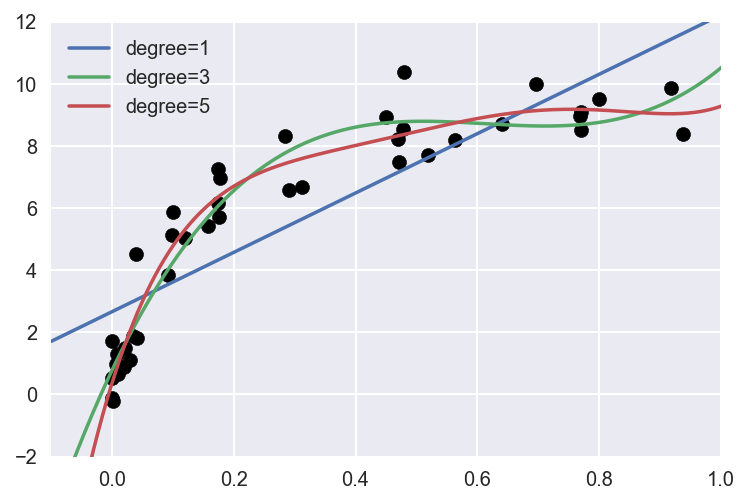

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


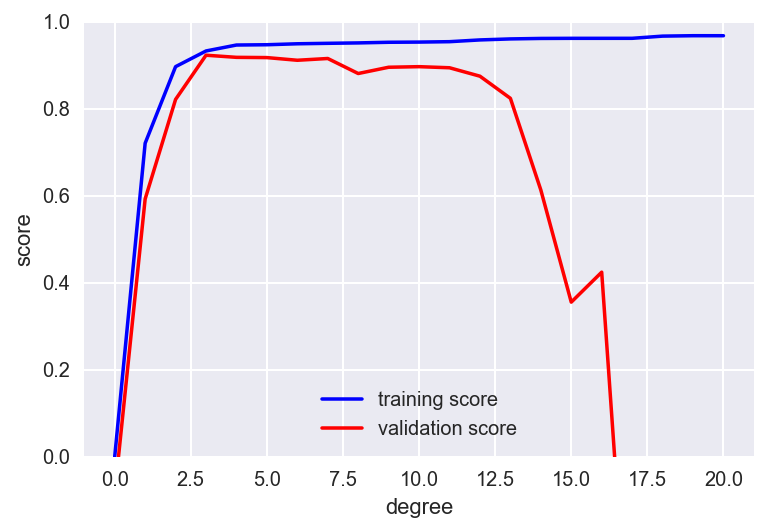

In [61]:
from sklearn.learning_curve import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

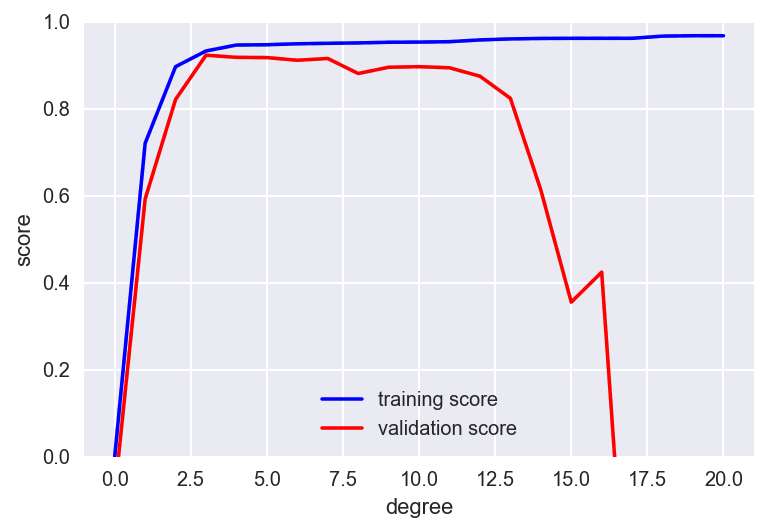

In [63]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X, y,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

In [ ]:
# Grid Search 

In [64]:
from sklearn.grid_search import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [65]:
grid.fit(X, y);

In [66]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

/Users/rishabhjain/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:3238: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


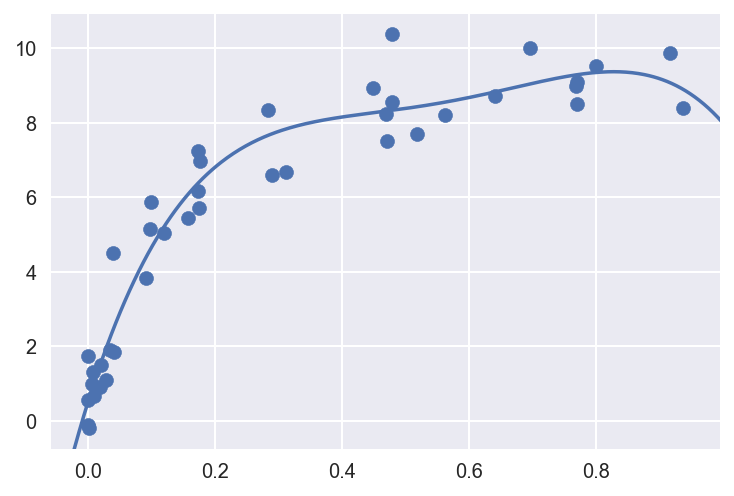

In [67]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test, hold=True);
plt.axis(lim);

In [69]:
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean')
X2 = imp.fit_transform(X)
imp

array([[  1.73907352e-01],
       [  5.18867376e-01],
       [  1.30815988e-08],
       [  9.14049845e-02],
       [  2.15372915e-02],
       [  8.52641608e-03],
       [  3.46928663e-02],
       [  1.19412216e-01],
       [  1.57424429e-01],
       [  2.90323473e-01],
       [  1.75724041e-01],
       [  4.69525764e-01],
       [  4.18007224e-02],
       [  7.71090232e-01],
       [  7.50080261e-04],
       [  4.49526682e-01],
       [  1.74143298e-01],
       [  3.12134324e-01],
       [  1.97084925e-02],
       [  3.92442000e-02],
       [  6.41191864e-01],
       [  9.37530479e-01],
       [  9.82347155e-02],
       [  4.79310604e-01],
       [  7.68057946e-01],
       [  8.00321082e-01],
       [  7.23251789e-03],
       [  1.52527609e-03],
       [  2.88423714e-02],
       [  7.71134256e-01],
       [  9.67209972e-03],
       [  1.77331632e-01],
       [  9.17552352e-01],
       [  2.84265221e-01],
       [  4.78693941e-01],
       [  9.95501134e-02],
       [  4.71283524e-01],
 

In [32]:
imp

NameError: name 'imp' is not defined

In [70]:
model = LinearRegression().fit(X2, y)
model.predict(X2)

array([  4.32585461,   7.62046757,   2.66491614,   3.53789847,
         2.87061243,   2.74634934,   2.9962575 ,   3.8053874 ,
         4.168431  ,   5.43771116,   4.34320528,   7.14922017,
         3.06414257,  10.02937479,   2.67207982,   6.95821475,
         4.32810806,   5.64602026,   2.8531461 ,   3.03972597,
         8.78875322,  11.61899723,   3.60312724,   7.24267234,
        10.00041431,  10.30855015,   2.73399169,   2.67948349,
         2.94038113,  10.02979526,   2.75729143,   4.35855891,
        11.42819195,   5.37985055,   7.23678277,   3.61569023,
         7.16600803,   9.31794034,   2.66811036,   8.03925775])

In [71]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(Imputer(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())

In [30]:
from sklearn.linear_model import LinearRegression

In [72]:
model.fit(X, y)  # X with missing values, from above
print(y)
print(model.predict(X))

[  7.24998644   7.70041705  -0.12288892   3.83970623   1.50418461
   1.31600899   1.88404109   5.0456151    5.42819209   6.59281674
   5.70193919   8.23148858   1.8305394    9.086429     1.73425177
   8.92229631   6.16043712   6.68597765   0.8992155    4.51082693
   8.70162943   8.39917725   5.14639037  10.37406543   8.96816213
   9.50648826   0.9746409   -0.20201375   1.09605993   8.50272859
   0.67301646   6.98083184   9.856233     8.32873282   8.55755817
   5.87386864   7.49515774   9.997533     0.54626444   8.1929663 ]
[ 5.21085248  9.29034256  1.3913101   3.54617659  1.92844858  1.60612545
  2.24763109  4.14110569  4.89953144  7.10739223  5.24451566  8.99180195
  2.41726904  9.33040045  1.41032135  8.84370491  5.21523183  7.40381263
  1.88354261  2.35648173  9.62020808  7.99544979  3.69407937  9.05856689
  9.34468135  9.17430945  1.57370963  1.42994641  2.10652049  9.33019047
  1.63477347  5.27419672  8.21285237  7.02175897  9.05446967  3.72235595
  9.00407135  9.57722696  1.39978

In [1]:
!pip install xgboost


  Using cached xgboost-0.7.post3.tar.gz
    Complete output from command python setup.py egg_info:
    ++ pwd
    + oldpath=/private/var/folders/k3/zxzdhqsn0z9gy8x69r6h6fqr0000gn/T/pip-build-56m3wfe7/xgboost
    + cd ./xgboost/
    + [[ darwin17 == \d\a\r\w\i\n* ]]
    + LIB_XGBOOST=libxgboost.dylib
    + make lib/libxgboost.dylib -j4
    Makefile:31: MAKE [/Library/Developer/CommandLineTools/usr/bin/make] - checked OK
    c++ -std=c++11 -Wall -Wno-unknown-pragmas -Iinclude   -I/private/var/folders/k3/zxzdhqsn0z9gy8x69r6h6fqr0000gn/T/pip-build-56m3wfe7/xgboost/xgboost/dmlc-core/include -Irabit/include -I/include -O3 -funroll-loops -msse2 -fPIC -fopenmp -MM -MT build/learner.o src/learner.cc >build/learner.d
    c++ -std=c++11 -Wall -Wno-unknown-pragmas -Iinclude   -I/private/var/folders/k3/zxzdhqsn0z9gy8x69r6h6fqr0000gn/T/pip-build-56m3wfe7/xgboost/xgboost/dmlc-core/include -Irabit/include -I/include -O3 -funroll-loops -msse2 -fPIC -fopenmp -MM -MT build/logging.o src/logging.cc >build